In [267]:
import os
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_absolute_error as mae
from scipy.fftpack import fft, fftfreq
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter, lfilter
import winsound

In [315]:
df = pd.read_excel("./calibration_data/RAW_DATA_FIXED.xlsx")
df = df.drop(columns=["Unnamed: 0", "Channel-23"])
df

,SETPOINT,Channel-17,Channel-18,Channel-19,Channel-20,Channel-21,Channel-22
0,20,8.6,8.6,8.6,9.7,10.1,9.3
1,20,8.6,8.6,8.6,9.7,10.1,9.3
2,20,9.0,8.6,9.3,9.3,10.1,9.3
3,20,8.6,9.0,9.7,9.7,9.7,10.1
4,20,8.6,8.6,9.0,9.3,9.3,9.3
...,...,...,...,...,...,...,...
1045,73,92.2,92.6,91.5,92.2,91.9,92.2
1046,73,92.2,92.6,91.5,92.2,91.9,92.2
1047,73,92.2,92.6,91.5,92.2,91.9,92.2
1048,73,91.5,93.3,91.1,91.1,91.9,91.9


In [497]:
class KalmanFilter(object):
    def __init__(self, dt, u, std_acc, std_meas):
        self.dt = dt
        self.u = u
        self.std_acc = std_acc
        self.A = np.matrix([[1, self.dt],
                            [0, 1]])
        self.B = np.matrix([[(self.dt**2)/2], [self.dt]]) 
        self.H = np.matrix([[1,0]])
        self.Q = np.matrix([[(self.dt**4)/4, (self.dt**3)/2],
                            [(self.dt**3)/2, self.dt**2]]) * self.std_acc**2
        self.R = std_meas**2
        self.P = np.eye(self.A.shape[1])
        self.x = np.matrix([[0],[0]])
    
    def predict(self):
        # Ref :Eq.(9) and Eq.(10)
        # Update time state
        self.x = np.dot(self.A, self.x) + np.dot(self.B, self.u)
        # Calculate error covariance
        # P= A*P*A' + Q
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + self.Q
        return self.x   
    
    def update(self, z):
        # Ref :Eq.(11) , Eq.(11) and Eq.(13)
        # S = H*P*H'+R
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
        # Calculate the Kalman Gain
        # K = P * H'* inv(H*P*H'+R)
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))  # Eq.(11)
        self.x = np.round(self.x + np.dot(K, (z - np.dot(self.H, self.x))))  # Eq.(12)
        I = np.eye(self.H.shape[1])
        self.P = (I - (K * self.H)) * self.P  # Eq.(13)

def calculate_kalman(DATA, u, std_acc):
    dt = DATA[1]-DATA[0]
    t = len(DATA)
    std_meas = np.std(np.array(DATA))   # and standard deviation of the measurement is 1.2 (m)
    # create KalmanFilter object
    kf = KalmanFilter(dt, u, std_acc, std_meas)
    predictions = []
    measurements = []
    for x in DATA:
        # Mesurement
        z = kf.H * x 
        measurements.append(z.item(0))
        predictions.append(kf.predict()[0])
        kf.update(z.item(0))

    return predictions

In [318]:
SET_POINT_INDEX = [i for i in np.unique(df.SETPOINT, return_index=True)[1]]
SET_POINT_INDEX.append(len(df.index))

df_concantenate = {
    "sensors" : [],
    "setpoint" : []
}

for i in range(0, len(SET_POINT_INDEX)-1):
    for j in df.keys():
        # Take data from each sensor and concantenate the data into 1 columns based on setpoint unique index
        # print(f"{j}, {SET_POINT_INDEX[i]}:{SET_POINT_INDEX[i+1]}")
        if j != "SETPOINT":
            for k in df[j][SET_POINT_INDEX[i]:SET_POINT_INDEX[i+1]]:
                df_concantenate["sensors"].append(k)
        
        else:
            for g in df[j][SET_POINT_INDEX[i]:SET_POINT_INDEX[i+1]]:
                for _ in range(6):
                    # Append data 7 times for 7 channels
                    df_concantenate["setpoint"].append(g)


In [319]:
df_concantenates = pd.DataFrame(df_concantenate)
df_concantenates

,sensors,setpoint
0,8.6,20
1,8.6,20
2,9.0,20
3,8.6,20
4,8.6,20
...,...,...
6295,92.2,73
6296,92.2,73
6297,92.2,73
6298,91.9,73


In [420]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='linear', input_shape=(1,)),
    tf.keras.layers.Dense(1)
])
model.summary()
learning_rate = 0.001
epochs = 100
batch_size = 32

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics = ["mae"])

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_59 (Dense)            (None, 32)                64        
                                                                 
 dense_60 (Dense)            (None, 1)                 33        
                                                                 
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [421]:
n = 1000  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
# yy = lfilter(b, a, df_concantenates.sensors.to_numpy())
yy = savgol_filter(df_concantenates.sensors.to_numpy(), 151, 5)

MAE_denoise = mae(yy, df_concantenates.setpoint)
MAE_denoise = round(MAE_denoise, 2)

polyreg_model = np.poly1d(np.polyfit(df_concantenates.sensors, df_concantenates.setpoint, 1))
polyreg_model = polyreg_model(df_concantenates.sensors)

x_train, x_test, y_train, y_test = train_test_split(df_concantenates.sensors, df_concantenates.setpoint, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train.to_numpy().reshape(-1, 1))
x_test = scaler.transform(x_test.to_numpy().reshape(-1, 1))
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test))

new_sensor_data = scaler.transform(df_concantenates.sensors.to_numpy().reshape(-1, 1))
predictions = model.predict(new_sensor_data)


MAE_RAW = mae(df_concantenates.sensors, df_concantenates.setpoint)
MAE_RAW = round(MAE_RAW, 2)
MAE_polyreg = mae(polyreg_model, df_concantenates.setpoint)
MAE_polyreg = round(MAE_polyreg, 2)


MAE_DL = mae(np.squeeze(predictions), df_concantenates.setpoint)
MAE_DL = round(MAE_DL, 2)

notification()

Epoch 1/100
158/158 [==============================] - 3s 7ms/step - loss: 2557.1287 - mae: 48.1764 - val_loss: 2365.2407 - val_mae: 46.0998
Epoch 2/100
158/158 [==============================] - 1s 5ms/step - loss: 2104.2124 - mae: 43.4955 - val_loss: 1752.8036 - val_mae: 39.3720
Epoch 3/100
158/158 [==============================] - 1s 5ms/step - loss: 1355.7867 - mae: 34.3388 - val_loss: 934.3837 - val_mae: 28.0296
Epoch 4/100
158/158 [==============================] - 1s 6ms/step - loss: 604.1245 - mae: 21.8384 - val_loss: 326.8511 - val_mae: 15.4533
Epoch 5/100
158/158 [==============================] - 1s 4ms/step - loss: 184.7377 - mae: 11.2000 - val_loss: 94.2553 - val_mae: 8.0302
Epoch 6/100
158/158 [==============================] - 1s 5ms/step - loss: 61.5521 - mae: 6.5046 - val_loss: 48.6587 - val_mae: 5.9817
Epoch 7/100
158/158 [==============================] - 1s 6ms/step - loss: 41.6450 - mae: 5.5949 - val_loss: 41.8177 - val_mae: 5.6133
Epoch 8/100
158/158 [===========

40/40 [==============================] - 0s 7ms/step - loss: 0.1629 - mae: 0.3140
Test Loss: 0.1629427969455719
Test MAE: 0.3140256702899933


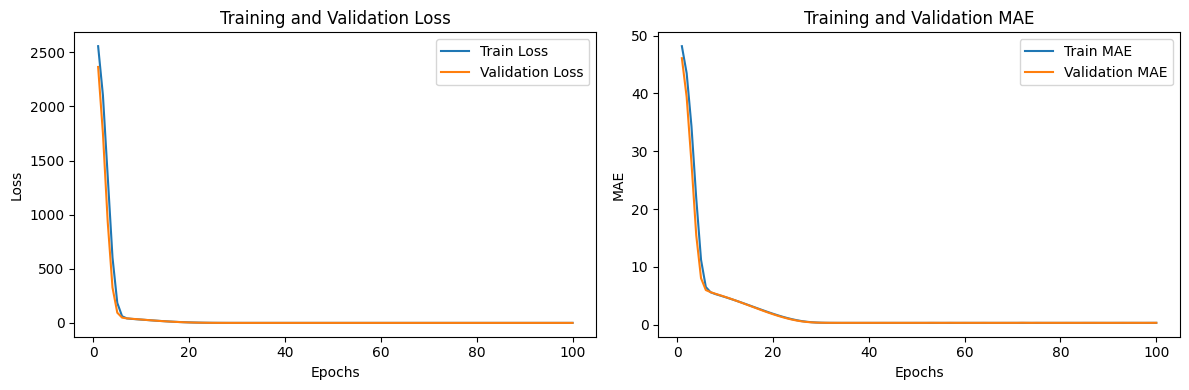

In [422]:
test_loss, test_mae = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)

# Step 8: Plot accuracy and loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_mae, label='Train MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()


In [498]:
n = 20  # the larger n is, the smoother curve will be
b = [1.0 / n] * n
a = 1
DL_filter = lfilter(b, a, df_concantenates.sensors.to_numpy())

DL_filter = savgol_filter(np.squeeze(predictions), 51, 10)
MAE_DL_Filter = mae(DL_filter, df_concantenates.setpoint)
MAE_DL_Filter = round(MAE_DL_Filter, 2)

polyreg_model_filter = savgol_filter(np.squeeze(predictions), 51, 10)
MAE_polyreg_Filter = mae(polyreg_model_filter, df_concantenates.setpoint)
MAE_polyreg_Filter = round(MAE_polyreg_Filter, 2)

kalman = np.squeeze(calculate_kalman(df_concantenates.sensors.to_list(), 51, 5))
MAE_kalman = mae(kalman, df_concantenates.setpoint)
MAE_kalman = round(MAE_kalman, 2)

moving_average = df_concantenates.sensors

8.6
8.6
9.0
8.6
8.6
8.6
7.4
7.4
8.6
9.7
8.6
8.2
8.2
8.2
8.6
8.2
9.0
8.6
7.8
7.8
9.0
9.3
9.0
9.3
8.2
8.2
8.6
8.6
9.3
8.2
8.2
8.6
8.6
9.3
9.0
9.0
9.0
8.6
7.8
8.6
9.0
8.6
8.6
9.3
9.0
9.7
9.0
8.6
8.6
8.6
8.6
8.6
8.6
9.0
8.6
9.0
9.0
9.0
9.0
8.2
9.3
9.0
9.3
9.3
9.0
8.2
9.0
8.6
10.1
10.1
9.0
8.2
8.6
9.0
9.0
9.0
8.6
8.2
9.3
7.8
7.8
9.7
9.0
8.6
9.7
7.8
7.8
8.2
9.3
9.7
8.2
7.8
7.8
9.0
9.7
8.6
9.0
8.2
8.2
9.3
8.6
8.6
9.3
9.7
9.0
9.7
9.0
9.0
9.3
9.3
9.3
8.6
9.3
9.3
9.7
9.3
9.3
9.3
9.0
9.0
9.3
9.7
9.3
9.0
9.0
9.0
9.0
8.6
9.3
8.6
8.6
9.3
9.0
10.1
9.7
9.3
9.3
9.0
9.3
9.0
9.0
9.0
9.0
9.3
9.3
9.7
9.3
9.0
9.0
9.3
9.7
9.7
9.3
9.7
9.3
9.7
9.3
9.3
9.3
9.7
9.3
9.0
9.3
9.3
9.3
9.0
9.7
10.1
9.3
9.3
10.5
10.1
9.7
9.7
9.3
9.3
9.3
9.7
9.7
9.3
9.3
9.7
9.3
10.5
9.7
9.7
9.7
9.3
9.7
9.0
9.7
9.0
9.0
9.3
9.7
9.7
9.3
9.0
9.0
9.7
10.1
10.1
10.1
9.7
9.3
10.1
9.3
9.3
9.7
9.7
9.7
9.0
10.5
10.5
10.1
9.7
10.5
10.5
9.7
9.7
10.1
9.7
10.1
10.1
9.3
9.3
9.3
9.3
10.5
9.0
9.0
10.5
9.7
10.5
9.7
9.7
9.7
9.7
9.7
9.3
9.7
9.3
9.3
9.7
10

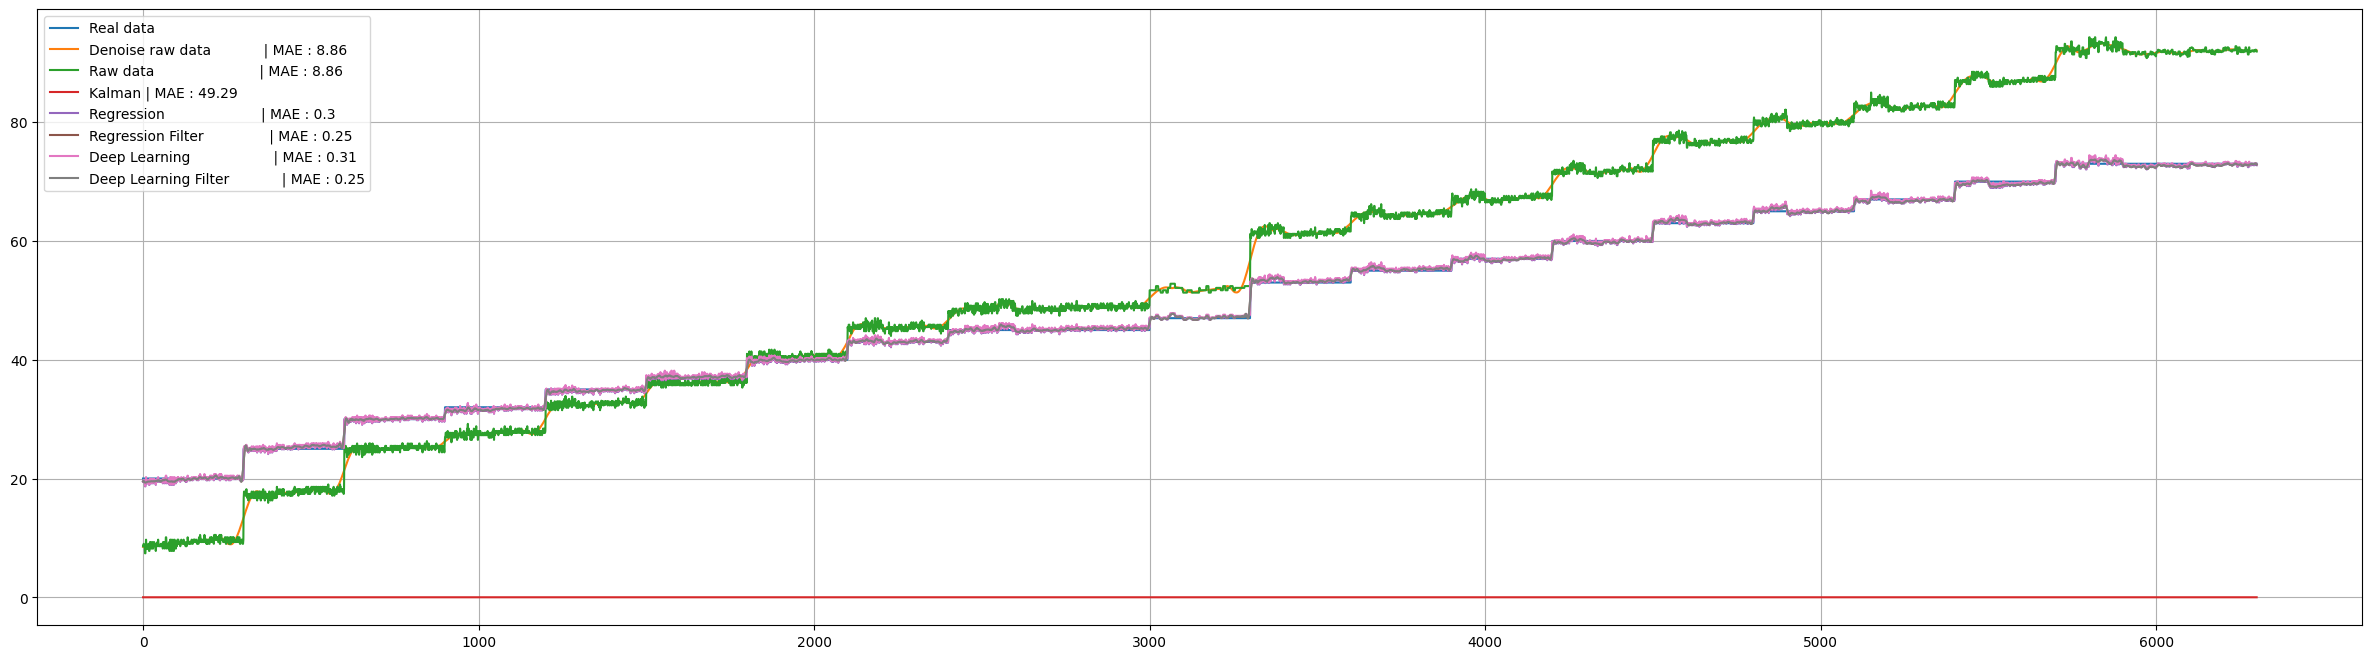

In [499]:
fig, ax = plt.subplots(figsize=(30, 8))

# ax.scatter([i for i in range(len(df_concantenates.sensors))],df_concantenates.sensors, label=f"Raw data | MAE : {MAE_RAW}", marker='x', color='k', s=10)
ax.plot(df_concantenates.setpoint,  label="Real data")
ax.plot(yy,                         label=f"Denoise raw data            | MAE : {MAE_denoise}")
ax.plot(df_concantenates.sensors,   label=f"Raw data                        | MAE : {MAE_RAW}")
ax.plot(kalman, label=f"Kalman | MAE : {MAE_kalman}")
ax.plot(polyreg_model,              label=f"Regression                      | MAE : {MAE_polyreg}")
ax.plot(polyreg_model_filter,       label=f"Regression Filter               | MAE : {MAE_polyreg_Filter}")
ax.plot(np.squeeze(predictions),    label=f"Deep Learning                   | MAE : {MAE_DL}")
ax.plot(DL_filter,                  label=f"Deep Learning Filter            | MAE : {MAE_DL_Filter}")

plt.grid()
plt.legend()
plt.show()